# EPO4 Assignment: ECG Preprocessing and Feature Extraction 

## Dataset: WESAD

please note that below are some simple techniques to get you started with processing ECG signals. After completening this assighnment you are free to choose you own approach and algorithms for the project.

## Dowload and read the data

To download the data go to [here](https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/), click on link in the download section. More information on dataset can be found[here](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29). If you are working in colab, an easy way to have access to the dataset is to upload it to you google drive. Go to [My Drive](https://drive.google.com/drive/my-drive) and use "new > folder upload" and upload the unzipped folder. Once the folder is uploaded you can read its files from colab. You only need to mount google drive on colab notebook every time you open your notebook. To do so,  go to "Files" on the vertical tab menu on right and click on "Mount Drive".

In [3]:
import os
import pickle
import numpy as np
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage

In [4]:
'''from google.colab import drive
drive.mount('/content/drive', force_remount=True)'''

"from google.colab import drive\ndrive.mount('/content/drive', force_remount=True)"

We need to define the dataset path and the subject ID

In [5]:
#S2 is Test data set, the other 14 will be used as training
data_set_path = "D:\Downloads\WESAD\WESAD\\"
subject = ["S2",'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

The class below allows you to access all the recordings and labels in the dataset.

In [6]:
class read_data_of_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        #os.chdir(path)
        #os.chdir(subject)
        with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data

    def get_labels(self):
        return self.data[self.keys[0]]

    def get_wrist_data(self):
        """"""
        #label = self.data[self.keys[0]]
        assert subject == self.data[self.keys[1]]
        signal = self.data[self.keys[2]]
        wrist_data = signal[self.signal_keys[0]]
        #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
        #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
        return wrist_data

    def get_chest_data(self):
        """"""
        signal = self.data[self.keys[2]]
        chest_data = signal[self.signal_keys[1]]
        return chest_data

In [7]:
# Object instantiation
obj_data_train = {}
obj_data_test = {}
 
# Accessing class attributes and method through objects 
#Test set
obj_data_test[subject[0]] = read_data_of_one_subject(data_set_path, subject[0])
print(obj_data_test[subject[0]].data)

#Train set
for i in range(1,len(subject)):
    
    obj_data_train[subject[i]] = read_data_of_one_subject(data_set_path, subject[i])
    print(obj_data_train[subject[i]].data)


{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682],
       [-1.12457275],
       

The code below allows you to read and print the length of all biosignals from the chest recording device recorded all at 700 Hz.

In [8]:
#######################
#Chest data set for TESTING
chest_data_dict_test = obj_data_test[subject[0]].get_chest_data()
print(type(chest_data_dict_test))

chest_dict_length_test = {key: len(value) for key, value in chest_data_dict_test.items()}
print(chest_dict_length_test)

print(chest_data_dict_test)

<class 'dict'>
{'ACC': 4255300, 'ECG': 4255300, 'EMG': 4255300, 'EDA': 4255300, 'Temp': 4255300, 'Resp': 4255300}
{'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
   

In [9]:
#######################
#Chest data set for TRAINING
for i in range(1,len(subject)):
    chest_data_dict_train = obj_data_train[subject[i]].get_chest_data()
    print(type(chest_data_dict_train))

    chest_dict_length_train = {key: len(value) for key, value in chest_data_dict_train.items()}
    print(chest_dict_length_train)

<class 'dict'>
{'ACC': 4545100, 'ECG': 4545100, 'EMG': 4545100, 'EDA': 4545100, 'Temp': 4545100, 'Resp': 4545100}
<class 'dict'>
{'ACC': 4496100, 'ECG': 4496100, 'EMG': 4496100, 'EDA': 4496100, 'Temp': 4496100, 'Resp': 4496100}
<class 'dict'>
{'ACC': 4380600, 'ECG': 4380600, 'EMG': 4380600, 'EDA': 4380600, 'Temp': 4380600, 'Resp': 4380600}
<class 'dict'>
{'ACC': 4949700, 'ECG': 4949700, 'EMG': 4949700, 'EDA': 4949700, 'Temp': 4949700, 'Resp': 4949700}
<class 'dict'>
{'ACC': 3666600, 'ECG': 3666600, 'EMG': 3666600, 'EDA': 3666600, 'Temp': 3666600, 'Resp': 3666600}
<class 'dict'>
{'ACC': 3826200, 'ECG': 3826200, 'EMG': 3826200, 'EDA': 3826200, 'Temp': 3826200, 'Resp': 3826200}
<class 'dict'>
{'ACC': 3656100, 'ECG': 3656100, 'EMG': 3656100, 'EDA': 3656100, 'Temp': 3656100, 'Resp': 3656100}
<class 'dict'>
{'ACC': 3847200, 'ECG': 3847200, 'EMG': 3847200, 'EDA': 3847200, 'Temp': 3847200, 'Resp': 3847200}
<class 'dict'>
{'ACC': 3663100, 'ECG': 3663100, 'EMG': 3663100, 'EDA': 3663100, 'Temp': 

You can also access the labels of each class. The following labels are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset.

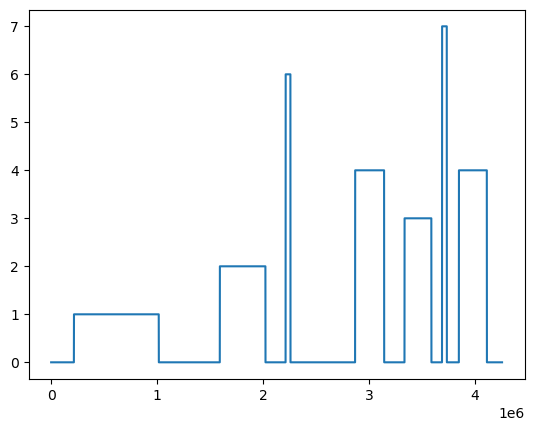

In [10]:
# Get labels
labels = obj_data_test[subject[0]].get_labels() 
baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 1])
stress = np.asarray([idx for idx,val in enumerate(labels) if val == 2])
plt.plot(labels)

In [11]:
def time_freq_plot(x, Fs, segment):
  
  # Reshape the signal into segments to creat matrix X, size (79, 163) of you drop samples
  num_segments = int(np.ceil(len(x)/(Fs*segment)))
  len_segments = int(np.floor(len(x)/num_segments))

  overshoot = len(x) - num_segments*len_segments
  
  if(overshoot != 0):
      x = x[0:-overshoot]
  X = np.reshape(x,(num_segments,len_segments))

In [12]:
'''print(baseline, '\n')
print(stress)

time=(np.max(baseline)-np.min(baseline))
print(time)
time_windows=time//100
window_length='''

SyntaxError: invalid syntax (611343785.py, line 7)

Let's load some part of the ECG signal during baseline recording

Text(0, 0.5, '$ECG$')

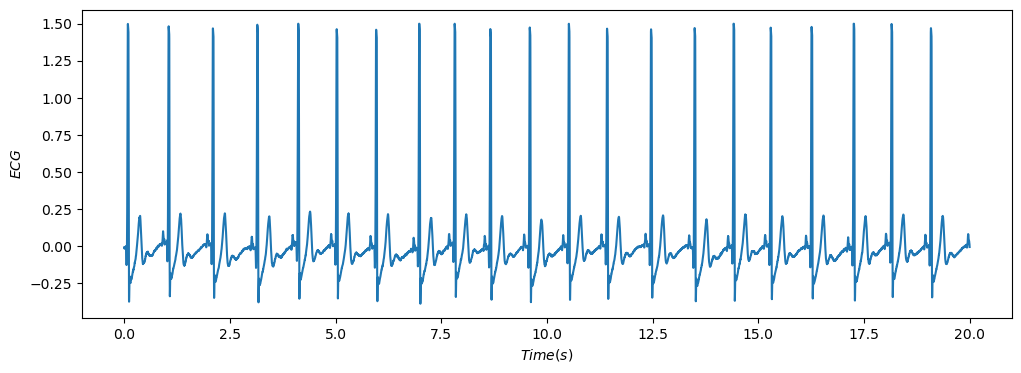

In [13]:
ecg_base=chest_data_dict_train['ECG'][baseline,0]
fs=700
# cut a smaller window
ecg=ecg_base[1000:1000+2* 10*fs]

t=np.arange(0,ecg.size*(1/fs),(1/fs))
t=t[:ecg.size]

plt.figure(figsize=(12,4))
plt.plot(t,ecg)
plt.xlabel('$Time (s)$') 
plt.ylabel('$ECG$') 

Text(0, 0.5, '$EDA$')

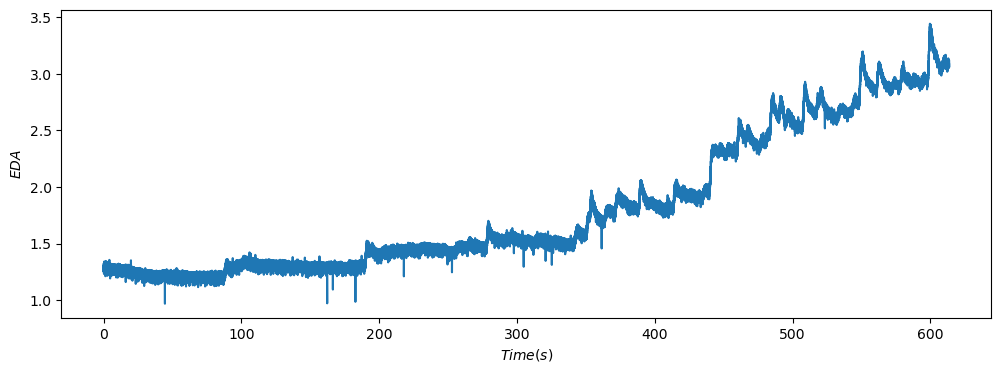

In [14]:
eda_base=chest_data_dict_test['EDA'][stress,0]
fs=700
# cut a smaller window
eda=eda_base[1000:1000+ 5*1000*fs]

t=np.arange(0,eda.size*(1/fs),(1/fs))
t=t[:eda.size]

plt.figure(figsize=(12,4))
plt.plot(t,eda)
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

## Filtering 
Below you can see how we can perform highpass, low pass and noth filtering on ECG recordings.

For the highpass and lowpass filter we use a 5th order digital butterworth with a normalized frequency, and output set to `output='ba'`. For the nuch filter we use the second-order IIR notch digital filter with `Q=30`.

ValueError: x and y must have same first dimension, but have shapes (429500,) and (14000,)

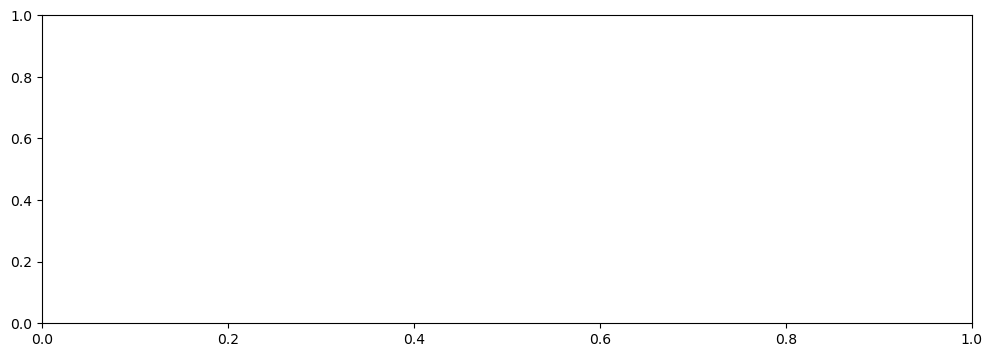

In [16]:
nyq = 0.5*fs
order=5

# highpass filter
high=0.5
high= high/nyq
b, a = butter(order, high, btype= 'highpass')
ecg_h = lfilter(b,a,ecg)

# lowpass filter
low=70
low= low/nyq
b, a = butter(order, low)
ecg_hl = lfilter(b,a,ecg_h)

# notch filter
notch=50
notch = notch/nyq
b, a = iirnotch(notch, 30, fs=fs)
ecg_hln = lfilter(b,a,ecg_hl)


plt.figure(figsize=(12,4))
plt.plot(t,ecg,label="raw ECG")
plt.plot(t,ecg_hln, label="filtered ECG")
plt.xlabel('$Time (s)$') 
plt.ylabel('$ECG$') 
plt.legend()

## R peak Detection
You can either develope your own code for r-peak detection or use the pan-tompkin approach for that. Pan-tompkins does some filtering on the data itself so you can just pass the raw data to it.

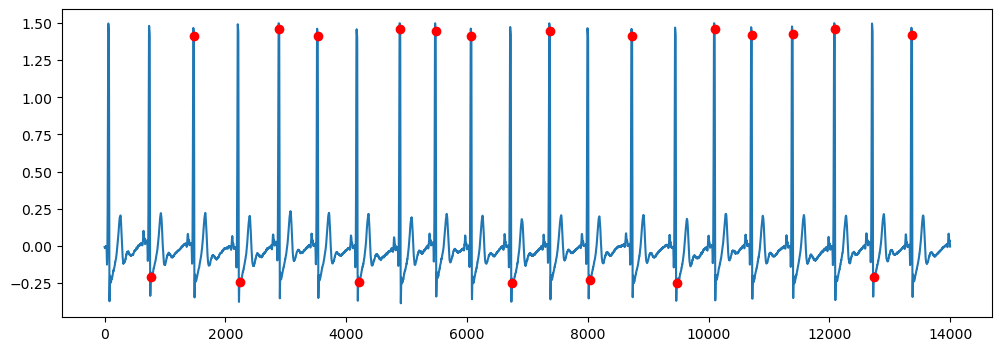

In [17]:
# detect R-peaks
from ecgdetectors import Detectors
detectors = Detectors(fs)

r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
r_peaks_pan = np.asarray(r_peaks_pan)

plt.figure(figsize=(12,4))
plt.plot(ecg)
plt.plot(r_peaks_pan,ecg[r_peaks_pan], 'ro')

4255300


ValueError: The length of the input vector x must be greater than padlen, which is 15.

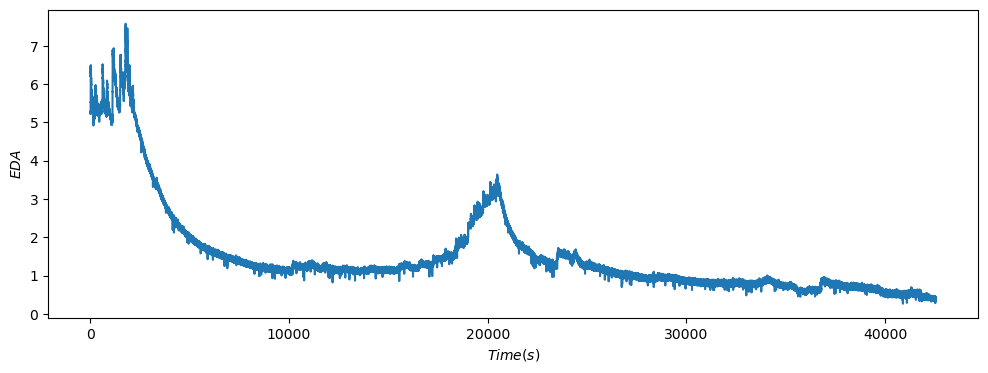

In [21]:
# eda recordings
eda = chest_data_dict_test['EDA']
print(len(eda))
# timestamps
eda_time = t=np.arange(0,ecg.size*(1/fs),(1/fs))
# sampling rate in Hz
sampling_rate = 700

"""let's plot 2 minutes of the raw recording"""

eda = eda[1000:1000+2*60*100] # 2 minutes of recording
t=np.arange(0,eda.size*0.01,0.01)
t=t[:eda.size]

plt.figure(figsize=(12,4))
plt.plot(t,eda)
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

# saving the figure as png
#plt.savefig('eda.png', dpi=300)

"""## Lowpass filtering
The first step to process the data is by low-pass filtering to remove high frequency noise. You can use `scipy.signal.butter()` to make a digital Butterworth lowpass filter of 4th order with cut-off frequency of  5Hz 
"""

############ lowpass filtering
# Parameters
Fs = sampling_rate 
order = 4 # your code here
frequency = 5 # your code here
sampling_rate = fs
frequency = frequency/(Fs/2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
eda_lp = scipy.signal.filtfilt(b, a, eda)

# plot
plt.figure(figsize=(12,4))
plt.plot(t,eda)
plt.plot(t,eda_lp)
#plt.xlim(70, 90)
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$')

"""# Smoothing

We can smooth the signal further (to improve peak detection) by using a hybrid smoothing method:
1. Using a one dimentional uniform filter `scipy.ndimage.uniform_filter1d()` with `mode='nearest'` and for size (length of the uniform filter) you can use 75% of the sampling rate.
2. Computing the moving average using `np.convolve()`. To do that you need to first make window using `scipy.signal.get_window` with `parzan` kernel, with the same size as previous step. Then  concatenate your signal to avoid boundry effect using `np.concatenate()`
"""

################################### Smoothing
# hybrid method
# step 1
size= int(0.75*Fs)# your code here
print(size)
eda_sm0 = scipy.ndimage.uniform_filter1d(eda_lp, 100, mode='nearest') # your code here
print(len(eda))
print(len(eda_sm0))
# step 2
# window
kernel="parzen"
window = scipy.signal.get_window(kernel, 2*size) # your code here
print('w:' , len(window))
w = window / window.sum()
print(eda_sm0[0])
# Extend signal edges to avoid boundary effects.
firstvalue = np.repeat(eda_sm0[0], size)
lastvalue = np.repeat(eda_sm0[-1], size)
eda_sm0 = np.concatenate((firstvalue, eda_sm0, lastvalue))# your code here
print(eda_sm0.size)
# Compute moving average.
eda_sm = np.convolve(w, eda_sm0, mode='same')# your code here

#eda_sm = eda_sm[:len(eda)]
eda_sm = eda_sm[size:-size]
print(eda_sm.size)
print(t.size)
# plot
plt.figure(figsize=(12,4))
plt.plot(t,eda)
plt.plot(t,eda_sm)
#plt.xlim(70, 90)
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

# saving the figure as png
#plt.savefig('eda_smoothed.png', dpi=300)

"""## Decomposition

As noted in the manual, the electrodermal activity is made of two components: phasic and tonic. A very simple approach for decomposing the signal into this two components is by using high and low pass filtering respectively. Use 5th order Butterworth filter with `output="sos"`. and cutoff frequency of 0.05 Hz.
"""

################## decompose 
# Electrodermal Activity (EDA) into Phasic and Tonic components.
# Phasic
order=5
freqs=[0.05]
sos = scipy.signal.butter(order, freqs, btype='high', output="sos", fs= Fs)
phasic= scipy.signal.sosfiltfilt(sos, eda_sm)

#Tonic
order=5
freqs=[0.05]
sos = scipy.signal.butter(order, freqs, btype='low', output="sos",  fs= Fs)
tonic= scipy.signal.sosfiltfilt(sos, eda_sm)

# plot
plt.figure(figsize=(12,4))
plt.plot(t,eda_sm,label='smooth_eda')
plt.plot(t,phasic,label='phasic')
plt.plot(t,tonic,label='tonic')
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 
plt.legend()

# saving the figure as png
#plt.savefig('eda_decomp.png', dpi=300)

"""## Peak Detection

The next step is to find the peaks of the phasic component (we don't need the tonic component anymore) as an indicator of the orienting responses. after finding all the peaks we only keep those with an amplitude larger than 0.1 and remove the rest. Use the following functions: `scipy.signal.find_peaks`,`scipy.signal.peak_prominences`,`scipy.signal.peak_widths`.
"""

import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences

peaks, _ = find_peaks(phasic)
heights, _, __ = peak_prominences(phasic, peaks)
widths, _, __, ___ = peak_widths(phasic, peaks, rel_height=0.63)

# find the indices with an amplitude larger that 0.1
keep = np.full(len(peaks), True)
amplitude_min=0.1
keep[peaks < 0.1] = False

# only keep those 
peaks=peaks[keep]
heights=heights[keep]
widths=widths[keep]

# plot
plt.figure(figsize=(12,4))
plt.plot(t,phasic,label='phasic')
plt.plot(t[peaks],phasic[peaks],'o',label='peaks')
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 
plt.legend()

"""## Onset and half recovery 

The next step now is to find the onset and half recovery time of each peak. complete theis notebook to so and plot your results.

The extracted features for each recording:
* The number of orienting responses: the number of peaks detected;
* The magnitude of orienting responses: the difference between the magnitude of the peak and its respective onset
* Half-recovery time: the duration between the peak to the half amplitude;
* The duration of orienting responses: the difference in time between the
onset and the offset

Onset: 63% of amplitude before the peak
Offset: 63% of amplitude after the peak

Data to be identified for each peak:
* Peak magnitude
* Onset magnitude and time instance
* Offset magnitude and time instance
* Half amplitude after the peak
"""

def calc_phasic_data(phasic, peak, height):
    ##Find all the points on the plot below the 50% of the peak
    half_points = np.where(((phasic - (phasic[peak] - 0.5*height) < 0.00001)))[0]

    ##Finds the index of the point directly to the right of the peak
    half_amp_index = np.inf
    for j in half_points:
      if(j < half_amp_index and j > peak):
        half_amp_index = j

    ##Half amplitude after the peak
    half_amp_val = phasic[half_amp_index]

    ##Calculate onset and offset
    onset_points = np.where(((phasic - (phasic[peak] - 0.63*height) < 0.00001)))[0]

    ##Finds the index of the point directly to the right of the peak
    offset_amp_index = np.inf
    for j in onset_points:
      if(j < offset_amp_index and j > peak):
        offset_amp_index = j

    offset_amp_val = phasic[offset_amp_index]

    ##Finds the index of the point directly to the right of the peak
    onset_amp_index = 0
    for j in onset_points:
      if(j > onset_amp_index and j < peak):
        onset_amp_index = j

    onset_amp_val = phasic[onset_amp_index]

    return onset_amp_index, half_amp_index, offset_amp_index


orienting_mag = np.asarray([], dtype = "float")
orienting_time = np.asarray([], dtype = "float")
half_recov_time = np.asarray([], dtype = "float")

for i in range(len(peaks)):
  onset_amp_index, half_amp_index, offset_amp_index = calc_phasic_data(phasic, peaks[i], heights[i])
  orienting_mag = np.append(orienting_mag, phasic[peaks[i]] - phasic[onset_amp_index])
  
  orienting_time = np.append(orienting_time, (offset_amp_index - onset_amp_index)/sampling_rate)
  half_recov_time = np.append(half_recov_time, (half_amp_index - peaks[i])/sampling_rate)



plt.plot(half_recov_time,orienting_time,'o',label='Peaks')
plt.xlabel('Half Recovery Time $(s)$') 
plt.ylabel('Time of Orienting Responses $(s)$')

Here is also some example feature you can extract using ecgdetectors 

In [ ]:
from hrv import HRV   # to import the module

hrv_class = HRV(fs)

feat_nn20=hrv_class.NN20(r_peaks_pan)
feat_nn50=hrv_class.NN50(r_peaks_pan)


   

Importing the LDA classifier

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda=LDA(n_components=2)
train_lda=lda.fit_transform(X_train, y_train)
test_lda=lda.fit_transform(X_test, y_test)


 